<a href="https://colab.research.google.com/github/kyulin6174/zeeman-slow-colab/blob/master/spinflip_zeeman_variablepitch_SI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




This piece of code calculates the field profile of the increasing field zeeman slower, as well as the coil profile. The idea of the zeeman slower is to utilize the zeeman shift from magnetic field to conpensate for the doppler shift, so that the slowing beam is always on resonance with the atomic transition during the slowing process. 

Mathematically, the slowing is induced by photon scattering process, whose rate $\gamma$ is 
\begin{equation}
\gamma=\frac{\Gamma}{2}\frac{I/I_{sat}}{1+I/I_{sat}+4\delta^2/\Gamma^2},
\end{equation}
and the corresponding acceleration excerted on atom is $a=\frac{dp}{mdt}$= $\hbar k \gamma/m$.

The zeeman slower coil produces a field that makes $\delta=0$ at all positions, which relates to the velocity in the folloing way:
\begin{equation}
\delta=\Delta+kv(z)-\frac{\mu}{\hbar}B(z)=0,
\end{equation}
where $\Delta$ is the bare detuning of the laser, $k$ is the laser wave-vector, and $\mu$ is the relative magnetic moment between the ground and excited state:
\begin{equation}
\mu=(g_em_e-g_gm_g)\mu_B,
\end{equation}
which for $^{162}Dy$ and $\sigma_+$ would be $m_e=9, g_e=1.22, m_g=8, g_g=1.24159$.

For zero detuning, atoms undergo motion of constant acceleration, whose velocity profile can be written as
\begin{equation}
v(z)=\sqrt{v_i^2-2az}, a=\frac{I/I_{sat}}{1+I/I_{sat}}a_{max}, 
\end{equation}

where $a_{max}=\frac{\hbar\Gamma k}{2m}=5.85*10^5m/s$. Assume $I=I_{sat}=58mW/cm^2$(270mW for 1 inch diameter), $a=0.5a_{max}$. With $v_i=\sqrt{\frac{3kT}{m}}=470m/s$, the length for the zeeman slower is $L=\frac{v_i^2}{2a}=0.378m$, so a 15" slowing region should be good.

The magnetic field profile is thus 
\begin{equation}
B(z)=\frac{\hbar k\sqrt{2a}}{\mu}\sqrt{L-z}+B_0,
\end{equation}
where $L=\frac{v_i^2}{2a},B_0=\frac{\Delta\hbar}{\mu}$

In [0]:
#@title 
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.constants import pi
from scipy.signal import argrelextrema

The coil that I plan to use has square geometry with OD 0.157" for the bare tubing. With kapton tape, the realistic OD is about 0.175". It is thus advisable to keep the pitch around 0.2" in order to have some safety space for epoxy and imperfect winding. The geometry that I'm imaging is thus a solenoid that can be approximated as a bunch of rings symmetric around the z axis. The cross section profile looks like a bunch of squares, each of them locate on a discretized "grid" position. (An example of the sectional view is shown at the last cell of this notebook, where the white boxes denote where the wires are wound)

To implement a spin-flip zeeman slower, the field has to be positive on one side of the slower, and negative on the other side. I decide to use seperate coil for the two regions since then I can controll the current of the two side independantly.
Mathematically, I encode the zeeman slower with its sectional profile, which is represented by matrix $M$. $M_{ij}=1$ represents a ring the i-th layer (at $r_{ij}=d+i * $coilthickness, d is the central vacuum tube thickness) and j-th slot in the axial direction ($z_{ij}=j*$coilthickness, z=0 denotes the entrance of the zeeman slower), and $M_{ij}=0$ represent no ring at such position. At z=z_a, the B field is thus
\begin{equation}
B_z|_{z=z_a}=\sum_{ij}M_{ij}\frac{\mu_0}{2}\frac{Ir_{ij}^2}{(r_{ij}^2+(z_a-z_{ij})^2)^{3/2}}.
\end{equation}
Finding the right coil configuration thus becomes a constrained optimation problem on $M_{ij}$.

For the purpose of the spin flip zeeman slower, since we have two separate sets of coil, we have two separate matrices $M_+$, $M_-$ with different amount of current $I_+$,$I_-$
running on them. In this case we have to slightly modify the expression of $B$ to 
\begin{equation}
B_z|_{z=z_a}=\sum_{ij}(M_+)_{ij}\frac{\mu_0}{2}\frac{I_+r_{ij}^2}{(r_{ij}^2+(z_a-z_{ij})^2)^{3/2}}+\sum_{ij}(M_-)_{ij}\frac{\mu_0}{2}\frac{I_-r_{ij}^2}{(r_{ij}^2+(z_a-z_{ij})^2)^{3/2}},
\end{equation}
and the optimization has to be done on both $M_+$ and $M_-$. The optimization process should be almost identical, though. 

# An visual example of M

I plot below an example of a 7 layer by 115 layer solenoid. Z direction on the plot is the axial direction of the zeeman slower, and r is the transverse direction. The Matrix is represented as a color map, where the white blocks are 1 representing the presence of coil, and black blocks are 0 representing the absence of coil. 

Text(0, 0.5, 'r')

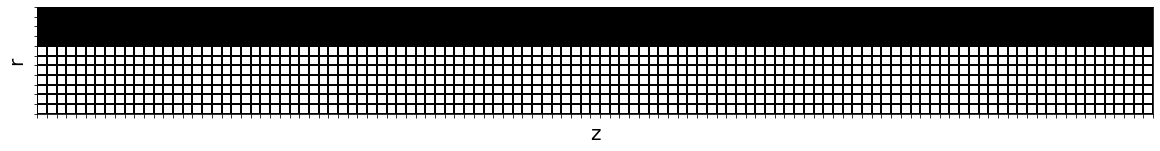

In [0]:
#@title Defining hyperparameters
zeeman_maxlayer_p=7
zeeman_maxlayer_n=11
length=115
layout_ex=np.zeros([zeeman_maxlayer_n,length])
for i in range(length):
    for j in range(zeeman_maxlayer_p):
        layout_ex[zeeman_maxlayer_n-1-j,i]=1
from matplotlib import colors
cmap = colors.ListedColormap(['black', 'white'])
bounds = [0,0.5,1]
norm = colors.BoundaryNorm(bounds, cmap.N)
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(layout_ex, cmap=cmap, norm=norm)
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(-0.5,length, 1))
ax.set_yticks(np.arange(-0.5,zeeman_maxlayer_n, 1))
xlabels = [item.get_text() for item in ax.get_xticklabels()];
empty_string_xlabels = ['']*len(xlabels);
ax.set_xticklabels(empty_string_xlabels);
ax.set_xlabel('z',fontsize=20)
ylabels = [item.get_text() for item in ax.get_yticklabels()];
empty_string_ylabels = ['']*len(ylabels);
ax.set_yticklabels(empty_string_ylabels);
ax.set_ylabel('r',fontsize=20)

# Coordinate system and overview of the scheme


Here I explain the dimensional parameters and the directional conventions. The +z direction is pointing from the oven to the production chamber. The center of the MOT is z=18.5" for some historical reasons in SeoHo's thesis and me failing in trying to be clever. (I could change that but it's much work...) 
The distance from the edge of the bias coil to the center of the MOT is 4.92", this sets the ultimate limit of the compensation coil. Currently the compensation coil is 3.1" (z=10.5") from the edge of the bias coil, and we would like to try to keep the position similar for the new version. The metric system is SI so all length variables has an extra 0.0254 factor. 

The zeeman slower is a spin-flip zeeman slower. Specifically, the field is pointing in the -z direction for the first half of the slower, and +z for the second half. The slower beam travels towards -z direction and is left-handed. Thus, if we adopt the quantization axis to be along the local field direction, then the light will be $\sigma_-$ polarized in the first (negative-field) section, and $\sigma_+$ in the second (positive-field) section. Due to the both optical pumping and the CG effect, only the stretch state with the cycling transition corresponding by the local light field can be efficiently slowed. Thus, only the atoms with $m_g = -8$ survives in the negative field section, and $m_g = +8$ survives in the negative field section. Between the positive field and negative field section there's a addition region of approximately zero magnetic field, which serves the purpose for optical pumping. Due to the residual background field, the $m_g=-8$ atoms would undergo avoided crossing and remain in $m_g=-8$ when it enters the zero-field region. The extended space for the zero-field region is to ensure that the atoms have sufficient time to equibriate with the now $\sigma_+$ polarized field and pumped to $m_g=8$, such that the positive field section can properly do subseqeuent cooling. 

Should we worry about field direction changing screwing up the sign of the zeeman term $\frac{\mu}{\hbar} B$? I think we should be ok due to the following argument: in the first section, the $\m_g=-8$ is the 

# Setting up the optimization problem 

In [0]:
#@title More hyperparameters
#coilx=np.arange(-10,11,0.2)*0.0254
zeemanx=np.arange(-8.6,8,0.2)*0.0254
sflength=13
zeemanx_sf=np.arange(-8.6-sflength*0.2,8,0.2)*0.0254
chamberx=np.arange(17.5,19.5,0.1)*0.0254
evalx=np.arange(-14,19,0.2)*0.0254
zeemanendpoint=0.0254*9.4#10.4
wirethickness=0.0254*0.19
length=115#2*6-2=10
crosspoint=52
tubethickness=0.0254*0.5#0.75
I=81#0.071#10
Ip=46
In=-20
zeeman_maxlayer_p=7
zeeman_maxlayer_n=11

Ideally, one would just optimize over all the possible $M$'s $\in [0,1]^{a\times b}$, where $a$ is the number of layers in the $r$ direction, and $b$ is the number of layers in the $z$ direction. However, discrete optimization is difficult since one cannot apply gradient descent methodds. One way that I found that turns out to work pretty well is to obtain continuous variable approximation $\tilde{M}$ of $M$ by standard gradient descent method, and discretize $\tilde{M}$ to obtain $M$. The method and the underlying assumptions are summarized as follows:

1. The coil never skips an orbit in the $r$ direction. Namely, if $M_{ij} = 1$ for some $i,j$ then $M_{i'j}$ can only be 1 for any $i'\leq i$. 

2. From 1 we know that the matrix $M$ can be described by a 1-d array $M^z\in \mathbb{N}^{1 \times b}$, where $M^z_j$ counts the outermost layer of the $j$-th column of $M$. We assume continum condition in r direction and approximate the sum with the integral:
\begin{equation}
B_z|_{z=z_a}=\sum_{ij}M_{ij}\frac{\mu_0}{2}\frac{Ir_{ij}^2}{(r_{ij}^2+(z_a-z_{ij})^2)^{3/2}}\\ 
\approx \sum_{j}\int_{r_0}^{r_0+d*M^z_j}dr\frac{\mu_0}{2}\frac{I r^2}{(r^2+(z_a-z_{j})^2)^{3/2}}
\end{equation} 

3. We can then first obtain a continuous variable approximation  $\tilde{M}$ of $M^z$ by minimzing the following objective function:
\begin{equation}
L = \sum_{z_a} \big(B_z|_{z=z_a}- \sum_{j}\int_{r_0}^{r_0+d*M^z_j}dr\frac{\mu_0}{2}\frac{I r^2}{(r^2+(z_a-z_{j})^2)^{3/2}}\big)^2 + Regularization. 
\end{equation} 
I take the regularizarion term to be the second order discrete derivative of the $\tilde{M}$ to avoid cusps in the actual coil. One can come up with something else.  

4. Finally, $M$ can be reconstructed from the apporximated $M^z= round(\tilde{M})$. 

5. Use the discrete sum to calculate the B field profile. If the result isn't satisfatory, do some modifications to the hyperparameters. 

In [0]:
#@title This function calculates B field from arbitrary $\tilde{M}$
def cal_Bfield_unitI(slot_filling,domainx):# single layer
    field=0*domainx
    for i in range(len(slot_filling)):
        d=tubethickness+1/2*wirethickness
        x_coil=zeemanendpoint-(i+1/2)*wirethickness
        field=field+slot_filling[i]*2*np.pi*10**(-3)*d**2/(d**2+(domainx-x_coil)**2)**(3/2)
    return field

In [0]:
#@title This function performs the discrete sum and calculates B based on M
def cal_Bfield_unitI_multidisc(slot_filling,domainx):#multi layer, and use sum instead of integral
    field=0*domainx
    fudge_1=1
    fudge_2=1
    for i in range(len(slot_filling)):
        for j in range(int(slot_filling[i])):
            d=tubethickness+(j+1/2)*fudge_1*wirethickness
            x_coil=zeemanendpoint-(i+1/2)*fudge_2*wirethickness
            field=field+2*np.pi*10**(-3)*d**2/(d**2+(domainx-x_coil)**2)**(3/2)
    return field

In [0]:
#@title This function takes into acconunt the thickness of each ring and does a more careful calculation of B based on M
def cal_Bfield_unitI_multi(slot_filling,domainx): #multi layer
    field=0*domainx
    for i in range(len(slot_filling)):
        d_in=tubethickness
        d_out=tubethickness+slot_filling[i]*wirethickness
        x_coil=zeemanendpoint-(i+1/2)*wirethickness
        ratio_out=np.abs(d_out/(x_coil-domainx))
        ratio_in=np.abs(d_in/(x_coil-domainx))
        int_upper=2*np.pi*10**(-3)*(np.arcsinh(ratio_out)-ratio_out/(1+ratio_out**2)**(1/2))
        int_lower=2*np.pi*10**(-3)*(np.arcsinh(ratio_in)-ratio_in/(1+ratio_in**2)**(1/2))
        field=field+int_upper/wirethickness-int_lower/wirethickness
    return field

In [0]:
#@title Append zeros. Just helper functions
def append_zeroes(vec, N, direction='front'): 
    #add zeros in front or back of the vector to target length N
    vec_new=np.zeros(N)
    if direction=='front':
      vec_new[-len(vec):]+=vec
    if direction=='back':
      vec_new[:len(vec)]+=vec
    return vec_new

In [0]:
#@title Smoothing function, another helper function
def mov_avg(vec, weight=0.1):#moving average, weight: how strong you weight the neighbors
    output=0*vec
    output[0]+=vec[0]
    output[-1]+=vec[-1]
    for i in range(1,len(vec)-1):
        output[i]+=(1-weight)*vec[i]+weight/2*vec[i-1]+weight/2*vec[i+1]
    return output

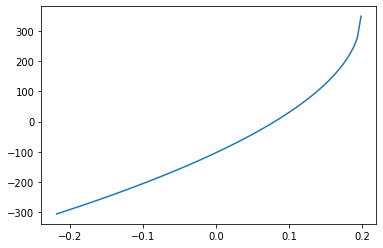

In [0]:
#@title Target field profile (in units of G) without the spinflip section
targetB=-1064*np.sqrt((-zeemanx+7.8*0.0254)*15/16.4)+350
plt.plot(zeemanx,targetB)

In [0]:
#@title The difference of field on the two ends

targetB[0]-targetB[-1]

-656.7560618189989

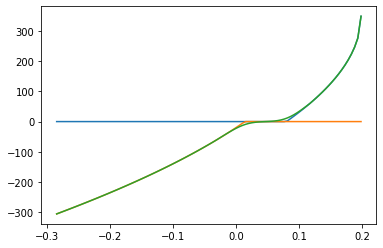

In [0]:
#@title Add a optical pumping section by extending the zero field region. Also smooth out the field profile a little bit. 
turnover_index=np.argmin(np.absolute(targetB))
targetB_pos=targetB[turnover_index:]
targetB_neg=targetB[:turnover_index]
targetB_pos=append_zeroes(targetB_pos,len(zeemanx_sf),'front')
targetB_neg=append_zeroes(targetB_neg,len(zeemanx_sf),'back')
targetB_sf=targetB_pos+targetB_neg
for _ in range(40):
    targetB_sf[50:80]=mov_avg(targetB_sf[50:80],0.3)

plt.plot(zeemanx_sf,targetB_pos)
plt.plot(zeemanx_sf,targetB_neg)
plt.plot(zeemanx_sf,targetB_sf)

In [0]:
#@title Laplacian penalty function for regularization 
def lap(vec):
    maxind=max(np.argmax(vec),np.int(len(vec)/2))
    #return np.linalg.norm(vec[2:maxind+2]-2*vec[1:maxind+1]+vec[:maxind])
    #return np.linalg.norm(vec[2:maxind+1]-2*vec[1:maxind]+vec[:maxind-1])
    #return np.linalg.norm(vec[2:maxind]-2*vec[1:maxind-1]+vec[:maxind-2])
    return np.linalg.norm(vec[2:]-2*vec[1:-1]+vec[:-2])

In [0]:
#@title L2 Residual error
def cal_error(vec1,vec2):
    return np.linalg.norm(vec1-vec2)

In [0]:
#@title Calculate residual error given target B field and coil profile
def cal_Berror(slot_filling):
    return cal_error(I*cal_Bfield_unitI_multi(slot_filling,zeemanx),targetB)+1000*lap(slot_filling)
def cal_Bperror(slot_filling):
    return cal_error(Ip*cal_Bfield_unitI_multi(slot_filling,zeemanx_sf),targetB_pos)+100*lap(slot_filling)
def cal_Bnerror(slot_filling):
    return cal_error(In*cal_Bfield_unitI_multi(slot_filling,zeemanx_sf),targetB_neg)+1000*lap(slot_filling)
def cal_Bsferror(slot_filling):
    coiln=append_zeroes(slot_filling[crosspoint:],length,'front')
    field_tot=Ip*cal_Bfield_unitI_multi(slot_filling[:crosspoint],zeemanx_sf)+In*cal_Bfield_unitI_multi(coiln,zeemanx_sf)
    return cal_error(field_tot,targetB_sf)+120*lap(slot_filling[:crosspoint])+15*lap(coiln)#20

In [0]:
#@title Discretization. Get $M^z$ out of $\tilde{M}$
fudge=1
def discretize_filling(slot_filling,I,normalize='m'):#normalize wrt to the MOT end or the Oven end
    if normalize=='m':
        output=np.zeros(len(slot_filling))
        I_out=I*slot_filling[0]/zeeman_maxlayer_p
        sum_c=0
        for i in range(len(slot_filling)):
            output[i]=int(sum_c+fudge*slot_filling[i]*I/I_out)-int(sum_c)
            sum_c+=fudge*slot_filling[i]*I/I_out
    if normalize=='o':
        output=np.zeros(len(slot_filling))
        I_out=I*slot_filling[-1]/zeeman_maxlayer_n
        sum_c=0
        for i in range(len(slot_filling)):
            output[-i-1]=int(sum_c+fudge*slot_filling[-i-1]*I/I_out)-int(sum_c)
            sum_c+=fudge*slot_filling[-i-1]*I/I_out
    return I_out,output

In [0]:
#@title Obtaining $\tilde{M}$ for the positive field section. Initial output wasn't optimal so I had to dicretize the output and feed that as the new initial guess. Also I needed to separately get M^z for positive and negative field section first and then combine to do another global fit. The reason for that is probably due to the B field profile being peculiar.  
import scipy.optimize as optimize
#slot_filling=np.zeros(length)
slot_filling=np.array([ 7.,  6.,  6.,  6.,  6.,  5.,  5.,  5.,  4.,  4.,  4.,  3.,  3.,
         3.,  2.,  3.,  2.,  1.,  2.,  1.,  1.,  2.,  0.,  1.,  1.,  0.,
         1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

#cons = [{'type':'ineq','fun':np.amin},{'type':'ineq','fun':neighbor_diff},{'type':'ineq','fun':max_cap}]
#cons = [{'type':'ineq','fun':np.amin}]
cons=[]
res = optimize.minimize(cal_Bperror,slot_filling,method='SLSQP',constraints=cons,options={'maxiter': 5000})
#res = optimize.minimize(grand_penalty,realI,method='SLSQP')

In [0]:
#@title Discretizing the output. Negative indices are unphysical but they can be taken care of at the overall profile optimization. 
I_disc,discrete_filling=discretize_filling(res.x,Ip)
I_disc,discrete_filling

(43.52800475357185,
 array([ 7.,  6.,  6.,  5.,  5.,  4.,  4.,  3.,  3.,  2.,  2.,  2.,  1.,
         1.,  1.,  2.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,
         1.,  0.,  0.,  0.,  1.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]))

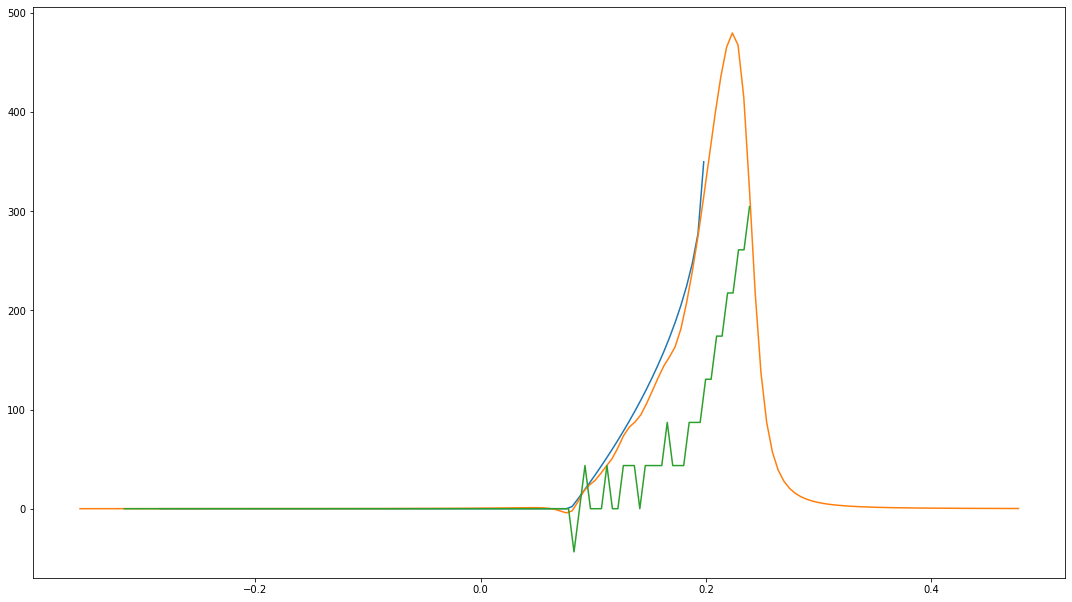

In [0]:
#@title Plotting target profile (blue), coil profile M^z (green) and the produced field profile (orange)
plt.plot(zeemanx_sf,targetB_pos)
#plt.plot(evalx,I*cal_Bfield_unitI_multi(res.x,evalx))
#plt.plot(zeemanendpoint-np.linspace(0,length,length)*wirethickness,30*res.x)
plt.plot(evalx,I_disc*cal_Bfield_unitI(discrete_filling,evalx))
#plt.plot(evalx,I_disc*cal_Bfield_unitI_multi(discrete_filling,evalx))
#plt.plot(evalx,I_disc*cal_Bfield_unitI_multidisc(discrete_filling,evalx))
plt.plot(zeemanendpoint-np.linspace(0,length,length)*wirethickness,I_disc*discrete_filling)
#plt.plot(zeemanx,targetB-I_disc*cal_Bfield_unitI_multi(discrete_filling,zeemanx))
#plt.plot(evalx,I*cal_Bfield_unitI_multi(res.x,evalx)-I_disc*cal_Bfield_unitI_multi(discrete_filling,evalx)))
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [0]:
#@title Obtaining $\tilde{M}$ for the negative field section. Initial output also wasn't optimal so I had to dicretize the output and feed that as the new initial guess. 
import scipy.optimize as optimize
#slot_filling=np.zeros(length)
slot_filling=np.array([  0.,   0.,  -1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  -1.,   0.,
          0.,   0.,   0.,   0.,  -1.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   2.,   2.,
          2.,   2.,   2.,   3.,   2.,   3.,   3.,   3.,   3.,   4.,   3.,
          4.,   4.,   3.,   5.,   4.,   4.,   4.,   5.,   5.,   5.,   5.,
          5.,   5.,   5.,   6.,   5.,   6.,   6.,   6.,   6.,   7.,   7.,
          6.,   7.,   8.,   7.,   8.,   7.,   8.,   9.,   8.,   9.,   9.,
          9.,   9.,  10.,   9.,  10.])

#cons = [{'type':'ineq','fun':np.amin},{'type':'ineq','fun':neighbor_diff},{'type':'ineq','fun':max_cap}]
#cons = [{'type':'ineq','fun':np.amin}]
cons=[]
res = optimize.minimize(cal_Bnerror,slot_filling,method='SLSQP',constraints=cons,options={'maxiter': 5000})
#res = optimize.minimize(grand_penalty,realI,method='SLSQP')

In [0]:
res;

In [0]:
#@title Discretization. Get $M^z$ out of $\tilde{M}$
I_disc,discrete_filling=discretize_filling(res.x,In,normalize='o')
I_disc,discrete_filling

(-14.056959045910562,
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,
         1.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,
         3.,  3.,  3.,  4.,  3.,  4.,  4.,  4.,  5.,  4.,  5.,  4.,  5.,
         5.,  5.,  5.,  5.,  6.,  5.,  6.,  5.,  6.,  6.,  6.,  7.,  6.,
         7.,  6.,  7.,  7.,  7.,  7.,  8.,  8.,  7.,  8.,  9.,  8.,  9.,
         8.,  9., 10.,  9., 10., 10., 10., 10., 11., 10., 11.]))

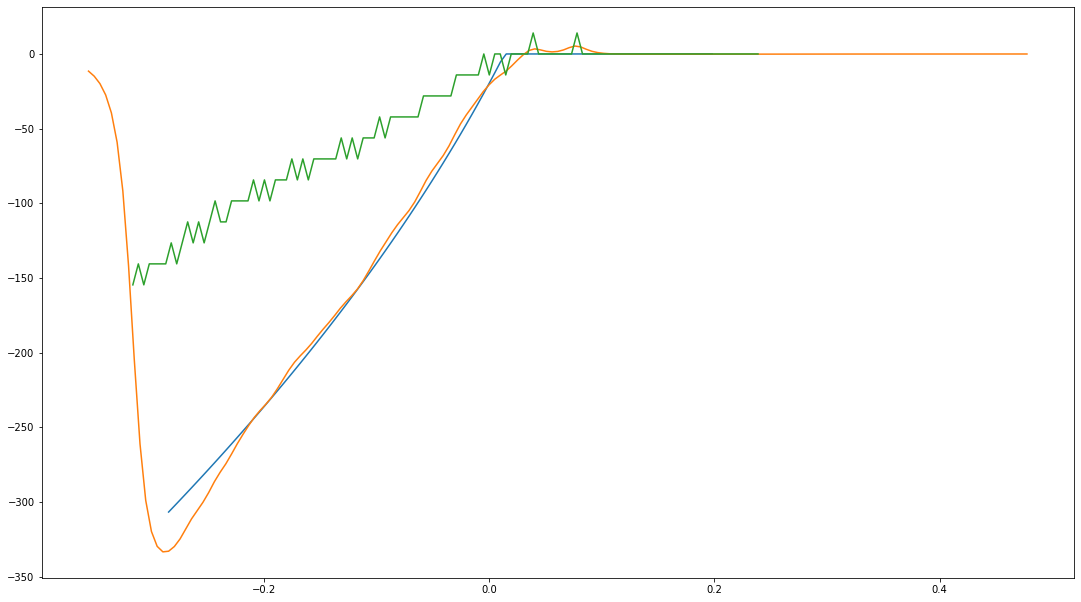

In [0]:
#@title Plotting target profile (blue), coil profile M^z (green) and the produced field profile (orange)
plt.plot(zeemanx_sf,targetB_neg)
#plt.plot(evalx,I*cal_Bfield_unitI_multi(res.x,evalx))
#plt.plot(zeemanendpoint-np.linspace(0,length,length)*wirethickness,30*res.x)
plt.plot(evalx,I_disc*cal_Bfield_unitI(discrete_filling,evalx))
#plt.plot(evalx,I_disc*cal_Bfield_unitI_multi(discrete_filling,evalx))
#plt.plot(evalx,I_disc*cal_Bfield_unitI_multidisc(discrete_filling,evalx))
plt.plot(zeemanendpoint-np.linspace(0,length,length)*wirethickness,I_disc*discrete_filling)
#plt.plot(zeemanx,targetB-I_disc*cal_Bfield_unitI_multi(discrete_filling,zeemanx))
#plt.plot(evalx,I*cal_Bfield_unitI_multi(res.x,evalx)-I_disc*cal_Bfield_unitI_multi(discrete_filling,evalx)))
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [0]:
#@title Combine the two $M^z$ from the previous optimization stages and combine them as the new initial guess for $\tilde{M}$ for the entire domain. Run gradient descent to get the final $\tilde{M}$
import scipy.optimize as optimize
#slot_filling=np.zeros(length)
slot_filling=np.array([ 7.,  6.,  6.,  5.,  5.,  4.,  3.,  3.,  2.,  2.,  2.,  1.,  2.,
         1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,
         0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])+np.array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,   0.,
          1.,   1.,   2.,   1.,   2.,   2.,   2.,   2.,   1.,   3.,   2.,
          2.,   2.,   3.,   2.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,
          4.,   3.,   4.,   3.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,
          5.,   4.,   5.,   5.,   4.,   5.,   5.,   5.,   5.,   4.,   5.,
          5.,   5.,   5.,   6.,   6.,   6.,   6.,   7.,   7.,   8.,   8.,
          9.,   9.,  10.,  10.,  11.])

#cons = [{'type':'ineq','fun':np.amin},{'type':'ineq','fun':neighbor_diff},{'type':'ineq','fun':max_cap}]
#cons = [{'type':'ineq','fun':np.amin}]
cons=[]
res = optimize.minimize(cal_Bsferror,slot_filling,method='SLSQP',constraints=cons,options={'maxiter': 5000})
#res = optimize.minimize(grand_penalty,realI,method='SLSQP')

In [0]:
#@title $\tilde{M}$
res.x

array([ 6.29817418e+00,  5.81765012e+00,  5.33769206e+00,  4.85955995e+00,
        4.38536659e+00,  3.91828517e+00,  3.46280935e+00,  3.02502733e+00,
        2.61283889e+00,  2.23584493e+00,  1.90444118e+00,  1.62764958e+00,
        1.41011603e+00,  1.24986989e+00,  1.13833940e+00,  1.06250237e+00,
        1.00798140e+00,  9.61875502e-01,  9.14571568e-01,  8.60438975e-01,
        7.97554506e-01,  7.26812402e-01,  6.50813500e-01,  5.72762736e-01,
        4.95636569e-01,  4.21670389e-01,  3.52207549e-01,  2.87851595e-01,
        2.28828982e-01,  1.75339007e-01,  1.27755487e-01,  8.66233737e-02,
        5.25054239e-02,  2.57851307e-02,  6.49401420e-03, -5.76630855e-03,
       -1.18094622e-02, -1.27768598e-02, -1.00040166e-02, -4.92871364e-03,
        9.74450557e-04,  6.17975424e-03,  9.09707364e-03,  8.03118444e-03,
        1.18506849e-03, -1.32431344e-02, -3.68584326e-02, -7.07415928e-02,
       -1.15027609e-01, -1.68536667e-01, -2.28645746e-01, -2.91782826e-01,
        2.08398249e-01,  

In [0]:
#@title Discretization to get the final $M^z$
I_disc_p,discrete_filling_p=discretize_filling(res.x[:crosspoint],Ip,normalize='m')
I_disc_n,discrete_filling_n=discretize_filling(res.x[crosspoint:],In,normalize='o')
discrete_filling_p=append_zeroes(discrete_filling_p,length,'back')
discrete_filling_n=append_zeroes(discrete_filling_n,length,'front')
discrete_filling_p=(discrete_filling_p+np.absolute(discrete_filling_p))/2
discrete_filling_n=np.array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         1.,  1.,  1.,  1.,  1.,  2.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,
         3.,  2.,  3.,  3.,  2.,  3.,  3.,  4.,  3.,  3.,  4.,  3.,  4.,
         4.,  4.,  4.,  4.,  4.,  5.,  4.,  4.,  5.,  5.,  5.,  5.,  5.,
         5.,  5.,  5.,  6.,  5.,  6.,  5.,  6.,  5.,  6.,  6.,  6.,  6.,
         6.,  7.,  7.,  7.,  8.,  9.,  9.,  9., 10., 10., 11.])
I_disc_p,discrete_filling_p,I_disc_n,discrete_filling_n
#zeemanfield_r=I_disc_p*cal_Bfield_unitI_multi(discrete_filling_p,zeemanx_sf)+I_disc_n*cal_Bfield_unitI_multi(discrete_filling_n,zeemanx_sf);
#cal_error(zeemanfield_r,targetB_sf)

(41.38800176029904,
 array([6., 7., 6., 5., 5., 5., 3., 4., 3., 2., 2., 2., 2., 1., 1., 1., 2.,
        1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 -18.017343504988002,
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         1.,  1.,  1.,  1.,  1.,  2.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,
         3.,  2.,  3.,  3.,  2.,  3.,  3.,  4.,  3.,  3.,  4.,  3.,  4.,
  

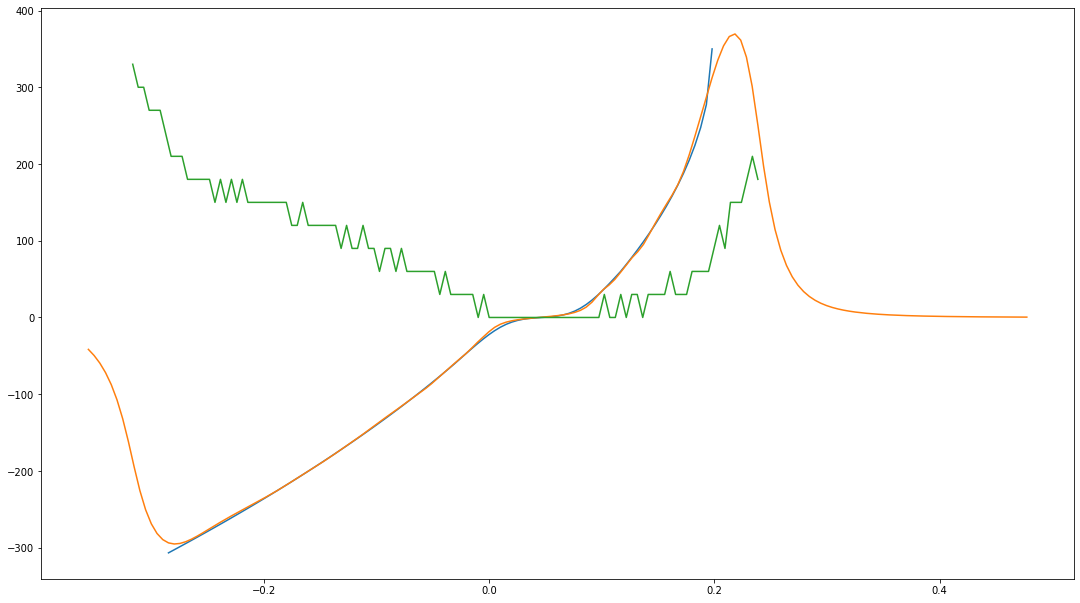

In [0]:
#@title Plot the target field profile(blue), actual field profile(orange) and the coil profile(green)
plt.plot(zeemanx_sf,targetB_sf)
#plt.plot(zeemanx_sf,targetB_pos)
#plt.plot(zeemanx_sf,targetB_neg)
plt.plot(evalx,I_disc_p*cal_Bfield_unitI_multi(discrete_filling_p,evalx)+I_disc_n*cal_Bfield_unitI_multi(discrete_filling_n,evalx))
#plt.plot(evalx,Ip*cal_Bfield_unitI(slot_filling[:crosspoint],evalx)+In*cal_Bfield_unitI(append_zeroes(slot_filling[crosspoint:],length,'front'),evalx))
#plt.plot(evalx,I_disc*cal_Bfield_unitI_multi(discrete_filling,evalx))
#plt.plot(evalx,I_disc*cal_Bfield_unitI_multidisc(discrete_filling,evalx))
plt.plot(zeemanendpoint-np.linspace(0,length,length)*wirethickness,30*(discrete_filling_p+discrete_filling_n))
#plt.plot(zeemanx,targetB-I_disc*cal_Bfield_unitI_multi(discrete_filling,zeemanx))
#plt.plot(evalx,I*cal_Bfield_unitI_multi(res.x,evalx)-I_disc*cal_Bfield_unitI_multi(discrete_filling,evalx)))
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

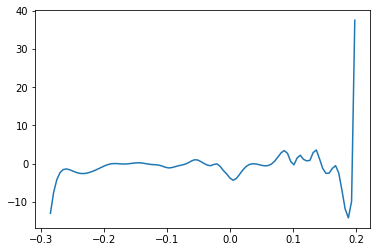

In [0]:
#@title Plot the spatial profile of field discrepency 
plt.plot(zeemanx_sf,targetB_sf-I_disc_p*cal_Bfield_unitI_multi(discrete_filling_p,zeemanx_sf)-I_disc_n*cal_Bfield_unitI_multi(discrete_filling_n,zeemanx_sf))


In [0]:
#@title Consctuct M using M^z
layout=np.zeros([zeeman_maxlayer_n,length])
for i in range(length):
    for j in range(int(np.int(discrete_filling_p[i]+discrete_filling_n[i]))):
        layout[zeeman_maxlayer_n-1-j,i]=1

Text(0, 0.5, 'r')

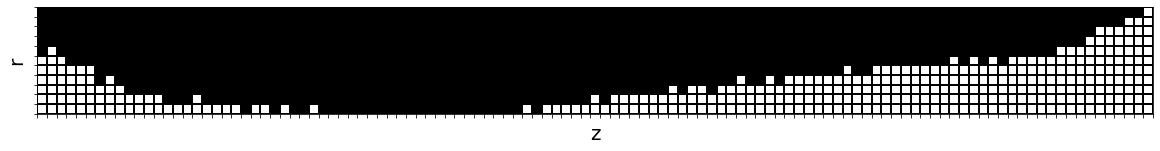

In [0]:
#@title Visualizing M
from matplotlib import colors
cmap = colors.ListedColormap(['black', 'white'])
bounds = [0,0.5,1]
norm = colors.BoundaryNorm(bounds, cmap.N)
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(layout, cmap=cmap, norm=norm)
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(-0.5,length, 1))
ax.set_yticks(np.arange(-0.5,zeeman_maxlayer_n, 1))
xlabels = [item.get_text() for item in ax.get_xticklabels()];
empty_string_xlabels = ['']*len(xlabels);
ax.set_xticklabels(empty_string_xlabels);
ax.set_xlabel('z',fontsize=20)
ylabels = [item.get_text() for item in ax.get_yticklabels()];
empty_string_ylabels = ['']*len(ylabels);
ax.set_yticklabels(empty_string_ylabels);
ax.set_ylabel('r',fontsize=20)

The last step is to do compensation. Zeeman coil induces a field gradient at the chamber center, which needs to be taken care of by an extra pair of coil. To compatify the setup, instead of using a setup similar to $M$ where one always start winding from the 0th layer, I assume one can just wind in the interval of [$M^{min}_i$,$M^{max}_i$]. (one can prove that for fix distance $(z_0-z_i)$, the coils with bigger r gives smaller gradient-to-field ratio, and the field profile at the center is such that I need to do this without having the coil going into the chamber)   Physically, to allow this setup one would need to make a holder that has inner radius corresponding to the $M^{min}_i$-th layer.

In [0]:
#@title Calculate the field profile from the compensation coil
def cal_Bfield_unitI_multidisc_compensate(layer_start,layer_stop,domainx,location):
    #multi layer, and use sum instead of integral
    #assume only one column of wire
    field=0*domainx
    for i in range(len(layer_start)):
        for j in range(layer_start[i],layer_stop[i]):
            d=tubethickness+(j+1/2)*wirethickness
            field=field+2*np.pi*10**(-3)*d**2/(d**2+(location+i*wirethickness-domainx)**2)**(3/2)
    return field

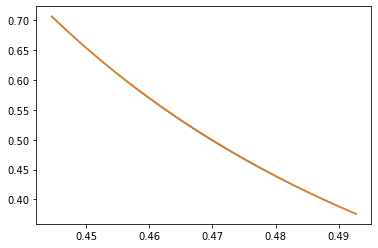

In [0]:
#@title Compare compensation coil field profiel to the zeeman slower field profile. I optimized by hand since there are almost as many hyperparameters as actual parameters and I didn't bother automating that process.
#compfield=70*cal_Bfield_unitI_multidisc_compensate([0,0,0,0,0],[11,11,11,0,0],chamberx,9.9*0.0254)-61.5*cal_Bfield_unitI_multidisc_compensate([0,0,0,0,0],[0,0,0,11,11],chamberx,9.9*0.0254)
compfield=31.7*cal_Bfield_unitI_multidisc_compensate([7,9,9,0,0],[11,11,11,0,0],chamberx,9.9*0.0254)-0*cal_Bfield_unitI_multidisc_compensate([0,0,0,0,0],[3,5,7,9,0],chamberx,9.9*0.0254)

plt.plot(chamberx,compfield)#9.9
plt.plot(chamberx,I_disc_p*cal_Bfield_unitI_multidisc(discrete_filling_p,chamberx)+I_disc_n*cal_Bfield_unitI_multidisc(discrete_filling_n,chamberx))

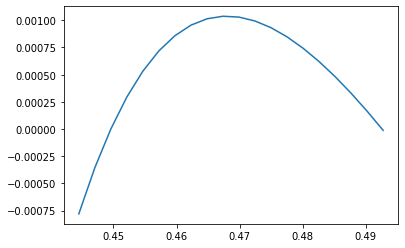

In [0]:
#@title The net field at MOT after adding the compensation coil
plt.plot(chamberx,I_disc_p*cal_Bfield_unitI_multidisc(discrete_filling_p,chamberx)+I_disc_n*cal_Bfield_unitI_multidisc(discrete_filling_n,chamberx)-compfield)


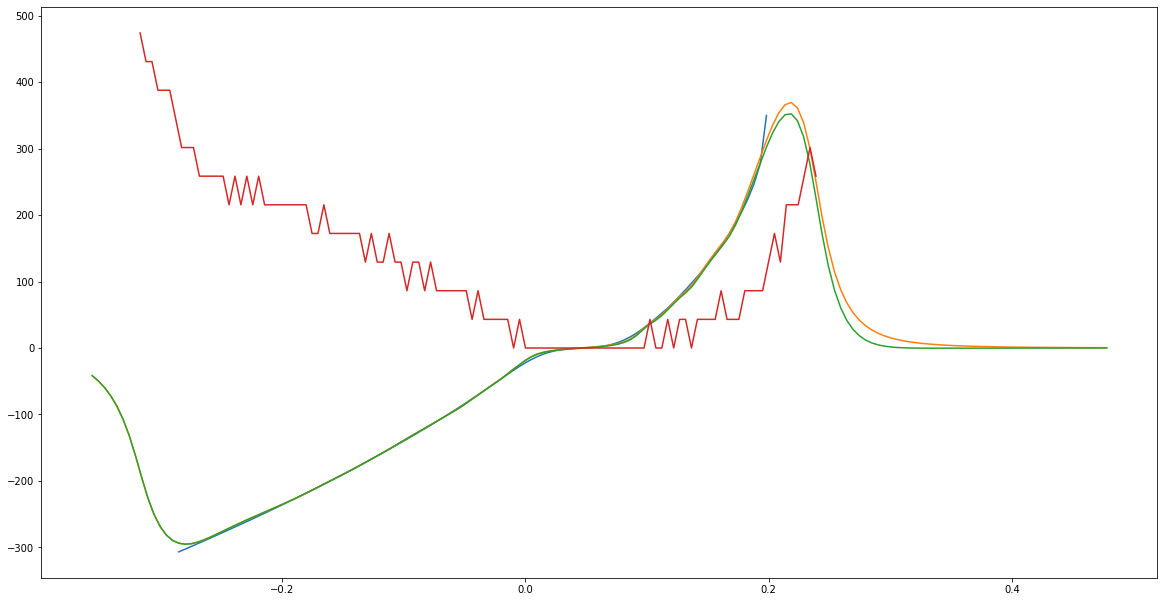

In [0]:
#@title Plotting the target field (blue), actual field w/o compensation (orange), actual field with compensation (green), and the zeeman coil profile
plt.plot(zeemanx_sf,targetB_sf)
plt.plot(evalx,I_disc_p*cal_Bfield_unitI_multi(discrete_filling_p,evalx)+I_disc_n*cal_Bfield_unitI_multi(discrete_filling_n,evalx))
plt.plot(evalx,I_disc_p*cal_Bfield_unitI_multidisc(discrete_filling_p,evalx)+I_disc_n*cal_Bfield_unitI_multidisc(discrete_filling_n,evalx)-32.2*cal_Bfield_unitI_multidisc_compensate([7,9,9,0,0],[11,11,11,0,0],evalx,9.9*0.0254))
#plt.plot(evalx,Ip*cal_Bfield_unitI(slot_filling[:crosspoint],evalx)+In*cal_Bfield_unitI(append_zeroes(slot_filling[crosspoint:],length,'front'),evalx))
#plt.plot(evalx,I_disc*cal_Bfield_unitI_multi(discrete_filling,evalx))
#plt.plot(evalx,I_disc*cal_Bfield_unitI_multidisc(discrete_filling,evalx))
plt.plot(zeemanendpoint-np.linspace(0,length,length)*wirethickness,43.1*(discrete_filling_p+discrete_filling_n))
#plt.plot(zeemanx,targetB-I_disc*cal_Bfield_unitI_multi(discrete_filling,zeemanx))
#plt.plot(evalx,I*cal_Bfield_unitI_multi(res.x,evalx)-I_disc*cal_Bfield_unitI_multi(discrete_filling,evalx)))
fig = plt.gcf()
fig.set_size_inches(20, 10.5)
#plt.ylim([300,400])
#plt.xlim([0.15,0.25])

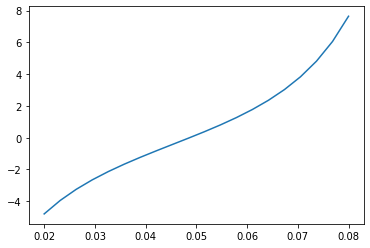

In [0]:
#@title Spinflip section. We can see that there are about 6cm region with field magnitude smaller than 10G. The sufficiency of length is justified by the optical pumping code. 
evalx_sf=np.linspace(0.02,0.08,20)
plt.plot(evalx_sf,I_disc_p*cal_Bfield_unitI_multidisc(discrete_filling_p,evalx_sf)+I_disc_n*cal_Bfield_unitI_multidisc(discrete_filling_n,evalx_sf)-32.2*cal_Bfield_unitI_multidisc_compensate([7,9,9,0,0],[11,11,11,0,0],evalx_sf,9.9*0.0254))


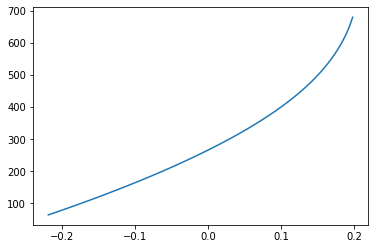

In [0]:
#@title Some random cell that doesn't matter I think. Will check later
targetB_comp=-1064*np.sqrt((-zeemanx+8*0.0254)*15/16.6)+720+100*cal_Bfield_unitI_multidisc_compensate([3,5,7,9,0],[11,11,11,11,0],zeemanx,9.9*0.0254)-100*cal_Bfield_unitI_multidisc_compensate([0,0,0,0,0],[3,5,7,9,0],zeemanx,9.9*0.0254)
plt.plot(zeemanx,targetB_comp)